In [1]:
%reload_ext autoreload
%autoreload 2

# Exploração - Wikipedia

In [2]:
from repository.mongo_utils import get_pages_content_collection, get_wikipedia_collection
from repository.wikipedia import WikipediaRepo

wikipedia_repo = WikipediaRepo(collection=get_pages_content_collection())
wikipedia_repo_brasil = WikipediaRepo(collection=get_wikipedia_collection('pages_content_brasil'))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup

### Obter todas as páginsa

In [4]:
pages = wikipedia_repo.find_all() + wikipedia_repo_brasil.find_all()

In [ ]:
from fonte_dados.wikipedia import Wikipedia

In [6]:
pages_df = pd.DataFrame(pages)
pages_df = pages_df.drop(['_id', 'ns', 'type', 'download', 'categories', 'wikitext'], axis='columns')

### Contagem de posts

In [7]:
print(f'Foram encontradas {len(pages_df)} páginas com contéudo')

Foram encontradas 3016 páginas com contéudo


## Exploração antes da limpeza

### Tamanho médio dos documentos

In [6]:
text_lengths = pages_df['text'].apply(len)
pages_df['raw_length'] = text_lengths

Algumas considerações

- Tamanho mínimo de 799 incluindo tags html indica que pode haver documentos muito pequenos
- Desvio padrão maior que a média indica que pode haver uma variação muito grande nos tamanhos dos documentos
    * Verificar quantiles para ver a variação por quartis

In [7]:
analisar_tamanhos = False

In [8]:
def describe_lengths(lenghts):
    print("Measures of Central Tendency")
    print("Mean =", np.mean(lenghts))
    print("Median =", np.median(lenghts))
    print("Measures of Dispersion")
    print("Minimum =", np.amin(lenghts))
    print("Maximum =", np.amax(lenghts))
    print("Range =", np.ptp(lenghts))
    print("Varience =", np.var(lenghts))
    print("Standard Deviation =", np.std(lenghts))

if analisar_tamanhos:
    describe_lengths(text_lengths)

In [9]:
if analisar_tamanhos:
    np.quantile(text_lengths, [0, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

#### Verificar distribuição de tamanhos de documentos

In [10]:
if analisar_tamanhos:
    sns.displot(pages_df, x='raw_length')

In [11]:
# Analisar documentos acima de 100000 caracteres
if analisar_tamanhos:
    pages_df_acima_100k = pages_df[pages_df['raw_length'] >= 100000]
    pages_df_acima_100k.shape

## Limpeza de dados

In [12]:
from limpeza.limpeza_texto import remover_html_tags

import re

In [13]:
texts = pages_df['text'].values
texto = texts[0] 


### Primeira  tentativa - removendo elementos individualmente

In [14]:
def remover_estilos_partes(texto):
    t = remover_html_tags(texto)
    t = re.sub('body\.skin\-[a-z]+ ', '', t)
    t = re.sub('.mw\-parser-[a-z]+ ', '', t)
    t = re.sub('t[hd]\.mbox\-[a-z]+[ ,]', '', t)
    t = re.sub('table\.[acfiot]mbox,', '', t)
    t = re.sub('table\.[acfiot]mbox\-[a-z]+,', '', t)
    t = re.sub('\.[ait]mbox[ ,]', '', t)
    t = re.sub('\.mbox\-[a-z]+[ ,]', '', t)
    t = re.sub('\.tmbox\.mbox\-[a-z]+[ ,]', '', t)
    t = re.sub('\.mediawiki ', '', t)
    t = re.sub('\.compact-ambox[ ,]', '', t)

    print(f'Tamanho do texto : {len(t)}/{len(texto)}')
    return t


### Segunda tentativa

- Peguei o conteúdo html, colei em um formatador externo e decidi tomar as seguintes ações
    * Remover tag ```<scripts>``` e todo seu conteúdo interno

In [15]:
# Pegando segundo texto, que tem tamanho 33027, mais perto da media
# [len(t) for t in texts[:20]]

texto = texts[3]

In [16]:
def remover_estilos_partes_2(texto):
    t = re.sub('<style .*?style>', '', texto) # Removendo tag de estilos
    print(f'Tamanho do texto apos remocao de estilos: {len(t)}/{len(texto)}. Aproximadamente {(len(t)/len(texto)) * 100:.2f}% mantido')

    t = re.sub('\n', '', t)
    t = re.sub('<table class="box-Sem_fontes.*?/table>', '', t)
    t = re.sub('<!--.*?-->', '', t) # Remover comentarios
    print(f'Tamanho do texto apos remocao conteudo: {len(t)}/{len(texto)}. Aproximadamente {(len(t)/len(texto)) * 100:.2f}% mantido')

    return t

## Extração de parágrafos

Após conseguir remover um pouco de texto na tentativa 2 anterior vamos extrair apenas textos de parágrafos e ver como fica o resultado. Um risco nesta abordagem é tirar conteúdos interessantes de tabelas ou listas mas deixar este problema de lado por enquanto.

- **Vou ignorar inclusive a limpeza de texto feito previamente e ir direto aos parágrafos.**
- **Avaliar possibilidade de pegar conteúdo <pre></pre>.**
- Uma análise posterior de tamanho dos documentos deve ser feita
- Deve-se remover tags html de dentro dos parágrafos pois estes podem conter elementos como links ou spans
    * **Isto é bem resolvido pelo método getText() do BeautifulSoup quando aplicado ao elemento p**
- **Esta foi a solução final adotada e a extração de texto puro foi feita no método *extrair_textos_puros* da classe *WikipediaCleaner* do pacote *limpeza.wikipedia***

In [17]:
executar_extracao_analise_paragrafos = False

Da primeira vez que executei o extrator de textos das páginas html ele demorou 38.5 segundos para extrair o conteudo de todas as páginas. Considerar se não vale a pena extrair e guardar este conteúdo MongoDB a partir do momento em que a extração já estiver definida.

In [18]:
def extract_texta(raw_text):
    soup = BeautifulSoup(raw_text, 'html.parser')
    ps = soup.find_all('p')
    pres = soup.find_all('pre')

    ps_text = ' '.join([p.getText() for p in ps])
    pres_text = ' '.join([pre.getText() for pre in pres])

    return (ps_text, pres_text)

if executar_extracao_analise_paragrafos:
    extracted = [extract_texta(t) for t in texts]
    tamanhos_pres = [len(ex[1]) for ex in extracted]
    tamanho_df = pd.DataFrame(tamanhos_pres, columns=['tamanhopre'])

In [19]:
if executar_extracao_analise_paragrafos:
    sns.histplot(tamanho_df, x='tamanhopre')

In [20]:
if executar_extracao_analise_paragrafos:
    tamanho_df['tamanhopre'].describe()

In [21]:
if executar_extracao_analise_paragrafos:
    # Apenas 3 páginas contém texto pre
    existe_pre = [ex[1] for ex in extracted if len(ex[1]) > 0]
    len(existe_pre)

In [22]:
if executar_extracao_analise_paragrafos:
    textos_completos = [ex[0] + ' ' + ex[1] if len(ex[1]) > 0 else ex[0] for ex in extracted]

In [23]:
if executar_extracao_analise_paragrafos:
    tamanhos_textos_completos = [len(t) for t in textos_completos]
    np.quantile(tamanhos_textos_completos, q=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

In [24]:
if executar_extracao_analise_paragrafos:
    # Breaks texts in words to count words
    texts_words = [t.split(' ') for t in textos_completos]

In [25]:
if executar_extracao_analise_paragrafos:
    tamanhos_em_palavras = [len(tw) for tw in texts_words]

In [26]:
if executar_extracao_analise_paragrafos:
    # The first command is to suppress the scientific notation
    np.set_printoptions(suppress=True)
    np.quantile(tamanhos_em_palavras, q=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

### Análise do tamanho de palavras

- [https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883](https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883)
- [https://www.researchgate.net/post/What-would-be-considered-the-least-number-of-documents-for-training-an-LDA-SLDA-topic-model-Is-a-corpus-of-200-documents-large-enough](https://www.researchgate.net/post/What-would-be-considered-the-least-number-of-documents-for-training-an-LDA-SLDA-topic-model-Is-a-corpus-of-200-documents-large-enough)
- [https://stackoverflow.com/questions/36673316/latent-dirichlet-allocationlda-performance-by-limiting-word-size-for-corpus-do](https://stackoverflow.com/questions/36673316/latent-dirichlet-allocationlda-performance-by-limiting-word-size-for-corpus-do)
- [https://www.machinelearningplus.com/topic-modeling-visualization-how-to-present-results-lda-models/](https://www.machinelearningplus.com/topic-modeling-visualization-how-to-present-results-lda-models/)
- [https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full](https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full)
- [https://arxiv.org/pdf/1904.07695.pdf](https://arxiv.org/pdf/1904.07695.pdf)

## Limpeza de conteúdo html (extrair apenas texto)

- Obter todas as páginas da collection *pages_content*
- Para cada página, utilizando campo *text*
    - Extrair apenas o texto puro
    - Gravar atrituto text_clean
- Foi implementado para isto o método *extrair_textos_puros* da classe *WikipediaCleaner* do pacote *limpeza.wikipedia*.

## Análise tamanhos textos

- **Com base nos textos puros extraídos dos htmls das páginas**

In [27]:
executar_extracao_analise_paragrafos = False

if executar_extracao_analise_paragrafos:
    pages = wikipedia_repo.find_all()
    textos_puros = [page['text_clean'] for page in pages]

In [28]:
# Analise de tamanho dos textos completos
if executar_extracao_analise_paragrafos:
    np.set_printoptions(suppress=True)
    tamanhos_textos_completos = [len(t) for t in textos_puros]
    np.quantile(tamanhos_textos_completos, q=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

In [29]:
# Analise da quantidade de palavras dos textos completos
if executar_extracao_analise_paragrafos:
    # Breaks texts in words to count words
    texts_words = [t.split(' ') for t in textos_puros]
    tamanhos_em_palavras = [len(tw) for tw in texts_words]

    # The first command is to suppress the scientific notation
    np.set_printoptions(suppress=True)
    print(np.quantile(tamanhos_em_palavras, q=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]))

## Limpeza de textos puros

In [47]:
from limpeza import limpeza_texto

from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [31]:
textos_puros = pages_df['text_clean'].values
deve_limpar_textos_puros = True

In [36]:
def limpar_texto_puro(texto_puro, remover_pontuacoes=True, remover_stopwords=True):
    texto_puro_limpo = texto_puro
    if remover_pontuacoes:
        texto_puro_limpo = limpeza_texto.remover_pontuacoes(texto_puro_limpo)

    tokens = word_tokenize(texto_puro_limpo)
    if remover_stopwords:
        tokens = limpeza_texto.remove_stopwords(tokens)

    tokens = limpeza_texto.stemm_text(tokens)

    return ' '.join(tokens)

textos_puros_limpos = []
if deve_limpar_textos_puros:
    # Na primeira execucao para todos os textos a execucao completa demorou cerca de 12 segundos
    textos_puros_limpos = [limpar_texto_puro(texto_puro) for texto_puro in textos_puros]

## Nuvem de palavras

In [44]:
all_text = ' '.join(textos_puros_limpos)

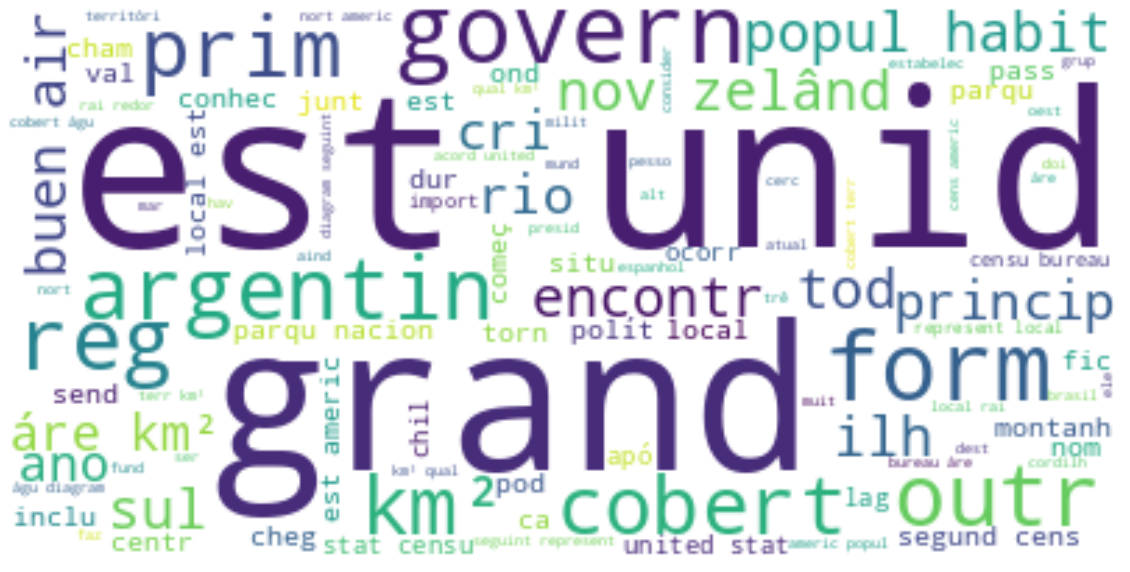

In [56]:
stop_words = set(STOPWORDS)
stop_words.update(['país', 'coorden', 'algum', 'desd', 'sobr', 'dev', 'exist', 'part', 'cidad', 'mai'])

cloud = WordCloud(max_words=100, background_color='white', stopwords=stop_words).generate(all_text)
plt.figure(figsize=(20, 20))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()